<a href="https://colab.research.google.com/github/bmoretz/MSDS-MachineLearning/blob/master/Shared/Team_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Workspace Initialization

## Libraries & Standard Setup

In [66]:
!pip install jupyterthemes

In [0]:
!pip install -U -q PyDrive

In [0]:
%matplotlib inline

import os
import io

# Core
import pandas as pd
import numpy as np

# Visuals
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import seaborn as sns

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# jt themes
from jupyterthemes import jtplot

# Display Images
from PIL import Image, ImageFilter

# IPython display
from IPython.display import display

# Loading Zip Files
import zipfile

# Working with images
import cv2

# Progress Bar (for long processes)
from tqdm import tqdm

In [0]:
import tensorflow as tf
import time

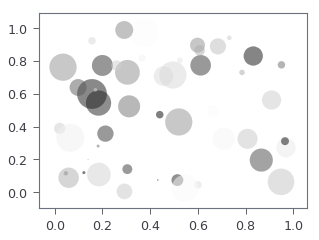

In [70]:
# Test Theme
!jt -t grade3 -f fira -fs 115
jtplot.style(theme='oceans16')

# set "context" (paper, notebook, talk, poster)
# scale font-size of ticklabels, legend, etc.
# remove spines from x and y axes and make grid dashed
jtplot.style(context='talk', fscale=1.4, spines=False, gridlines='--')

# turn on X- and Y-axis tick marks (default=False)
# turn off the axis grid lines (default=True)
# and set the default figure size
jtplot.style(ticks=True, grid=False, figsize=(6, 4.5))

N = 50
x = np.random.rand(N)
y = np.random.rand(N)
colors = np.random.rand(N)
area = (30 * np.random.rand(N))**2

plt.scatter(x, y, s=area, c=colors, alpha=0.5)
plt.show()

Looks good. Let's roll.

### Utility

Function to make output stable across runs.

In [0]:
def reset_graph(seed= RANDOM_SEED):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

## Globals

In [0]:
RANDOM_SEED = 42

IMG_WIDTH = 50
IMG_HEIGHT = 50
IMG_CHANNELS = 1

# Project Dataset

## Cats Vs. Dogs Training Data

Load the cats vs. dogs dataset from mounted drive.

In [73]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
def label_img(img_name):
  if 'cat' in img_name: return [1, 0]
  elif 'dog' in img_name: return [0, 1]

In [140]:
training_data = []

with zipfile.ZipFile('/content/drive/My Drive/datasets/cats_vs_dogs/train.zip', 'r') as z:
  for fn in tqdm(z.namelist()):
    if not os.path.isdir(fn) and fn.endswith("jpg"):
      label = label_img(fn)

      img_str = z.read(fn)

      nparr = np.frombuffer(img_str, np.uint8)

      img_np = cv2.imdecode(nparr, cv2.IMREAD_GRAYSCALE)
      img = cv2.resize(img_np, (IMG_WIDTH, IMG_HEIGHT))

      training_data.append([ np.array(img), np.array(label)])

100%|██████████| 25001/25001 [00:32<00:00, 772.03it/s]


## Data Set Exploration

In [172]:
training_data[0]

[array([[168, 174, 177, ..., 211, 208, 205],
        [168, 174, 177, ..., 213, 209, 206],
        [168, 174, 177, ..., 216, 210, 208],
        ...,
        [127, 129, 132, ...,   3,   3,   2],
        [126, 128, 131, ...,   3,   3,   3],
        [123, 125, 129, ...,   2,   2,   2]], dtype=uint8), array([1, 0])]

### Graphical Utility

Peek an image and it's label from the training data.

In [0]:
def peek_img( index, data = training_data):
  img_type = 'Unknown'
  
  if np.array_equal(data[index][1], [1, 0]): img_type = 'Cat'
  elif np.array_equal(data[index][1], [0, 1]): img_type = 'Dog'
  
  imshow(data[index][0], cmap = 'gray', interpolation = 'bicubic')
  plt.title(img_type)
  plt.show()

Show an image in grey scale format.

### Raw Image Data

Let's explore some of the training data. We'll start with the first image in the set in its raw form.

In [177]:
X_train[0]

array([[168, 174, 177, ..., 211, 208, 205],
       [168, 174, 177, ..., 213, 209, 206],
       [168, 174, 177, ..., 216, 210, 208],
       ...,
       [127, 129, 132, ...,   3,   3,   2],
       [126, 128, 131, ...,   3,   3,   3],
       [123, 125, 129, ...,   2,   2,   2]], dtype=uint8)

### Graphical Version

Now, let's view the actual image.

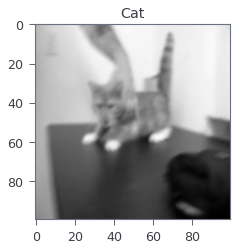

In [180]:
peek_img(0)

### Label verification

Now let's find a dog and make sure it's labeled correctly.

In [199]:
[i for x, y in enumerate(training_data) if np.array_equal(y, [0, 1])]

[]

25000

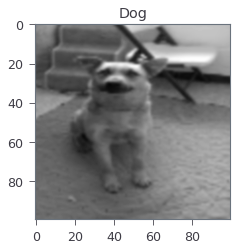

In [202]:
first_dog = Y_train.index('Dog')
peek_img(16000)

In [118]:
X_shaped = X_train.reshape(-1, 1)

AttributeError: ignored

# Deep Classification Model

Reset model to default state.

In [0]:
reset_graph()

## Model Input

In [0]:
n_inputs = IMG_WIDTH * IMG_HEIGHT * IMG_CHANNELS

Each input is a 100x100x1 array, for a toal of 10,000 data points.

In [115]:
n_inputs

10000

## Model Output

Total outputs for a binary classifier is 2, cat or dog.

In [0]:
n_outputs = 2

TensorFlow variables.

## Model Variables

In [0]:
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [0]:
def neuron_layer(X, n_neurons, name, activation=None):
    with tf.name_scope(name):
        n_inputs = int(X.get_shape()[1])
        stddev = 2 / np.sqrt(n_inputs)
        init = tf.truncated_normal((n_inputs, n_neurons), stddev=stddev)
        W = tf.Variable(init, name="kernel")
        b = tf.Variable(tf.zeros([n_neurons]), name="bias")
        Z = tf.matmul(X, W) + b
        if activation is not None:
            return activation(Z)
        else:
            return Z

300 and 100 nodes for layers 1 and 2 as used with MNIST from Geron.

## Hidden Layers

In [0]:
n_hidden1 = 300
n_hidden2 = 100

### Deep Neural Network

In [114]:
with tf.name_scope("dnn"):
    hidden1 = neuron_layer(X, n_hidden1, name="hidden1",
                           activation=tf.nn.relu)
    
    hidden2 = neuron_layer(hidden1, n_hidden2, name="hidden2",
                           activation=tf.nn.relu)
    
    logits = neuron_layer(hidden2, n_outputs, name="outputs")

ValueError: ignored

In [112]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                              logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

ValueError: ignored

In [0]:
learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)
    
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))    

In [0]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

Concatenate the individual images into a single input array.

In [0]:
X_cat_dog = np.concatenate(X_train, axis = 0) 

2500000